# Notebook 5: Accessing satellite imagery of OU campus

In previous notebooks we have begun to explore vector and raster data related to land use on the OU campus. Now we are going to learn about using Python to access and work with satellite imagery.

In this notebook we will:

- **acquire satellite image data** (both Sentinel-2 and Landsat) from **Microsoft's Planetary Computer**,
- build a basic understanding of the **structure and data content** of these satellite created images,
- explore basic **viewing and manipulation of satellite imagery**.

In [1]:
# Need to do some date math and need to work with file paths
from datetime import timedelta
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [3]:
from IPython.display import Image
from PIL import Image as PILImage

In [4]:
%matplotlib inline

The general steps we'll use to pull satellite data are:

   1. Establish a connection to the Planetary Computer's STAC API using the `planetary_computer` and `pystac_client` Python packages.

   2. Query the STAC API for recent scenes that capture the OU campus. We will use only Sentinel-2 L2A data.

   3. Select one image that is recent and has low cloud cover.

# 

I picked one from early April 1, 2024 that looked relatively cloud free. After selecting an image item, you'll be able to click on the squiqqly brackets icon to get a Python code snippet for accessing this item via the PyStac API. Here's the snippet:

In [5]:
import pystac
import planetary_computer
import rioxarray

item_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20240401T162831_R083_T17TLH_20240402T014917"

# Load the individual item metadata and sign the assets
item = pystac.Item.from_file(item_url)

signed_item = planetary_computer.sign(item)

# Open one of the data assets (other asset keys to use: 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'preview')
asset_href = signed_item.assets["AOT"].href
ds = rioxarray.open_rasterio(asset_href)
ds




<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

There's much to be learned from a careful look at this code. First, the imports.

- `pystac` - we need this work work with MPC's STAC API
- `planetary_computer` - even though MPC allows free access via the STAC API, we need this library in order to *sign* the item we are trying to retrieve. As we'll see later, this results in a long token string getting appended to the item URL. More on signing later.
- `rioxarray` - as we saw in the introduction to raster data, rioxarray is needed to open the actual raster image file and tuck it into an xarray `DataArray`.

Now for the `item_url`. It looks like this:

    https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/
    S2A_MSIL2A_20240401T162831_R083_T17TLH_20240402T014917
    
We see from the URL that:

- we are going to be using the STAC API
- this image is from the Sentinel-2 mission
- this is Level 2A data
- this particular image is one of a larger collection of image items
- the particular image has a unique id of `S2A_MSIL2A_20240401T162831_R083_T17TLH_20240402T014917`

Notice that the *datatake sensing time* (a date and time) are embedded in the `id`. The `id` naming conventions are explained at [https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention) which also includes links to detailed product specification pages.

The `S2A` is the *mission id* and the `MSIL2A` is:

> MSIL2A denotes the Level-2A product level

The `R083` is is the *relative orbit number* and the `T17TLH` is a *tile number field* and the second datetime is:

> The second date is the \<Product Discriminator> field, which is 15 characters in length, and is used to distinguish between different end user products from the same datatake. Depending on the instance, the time in this field can be earlier or slightly later than the datatake sensing time.


Grab the image item and sign it.

```python
item = pystac.Item.from_file(item_url)
signed_item = planetary_computer.sign(item)
```

We are just passing the URL for the item we want and using `pystac` to get it and `planetary_computer` to sign it. If it's not signed, we won't be able to access its details. Let's explore this PyStac `Item` object.

In [6]:
print(signed_item)

<Item id=S2A_MSIL2A_20240401T162831_R083_T17TLH_20240402T014917>


What about the attributes of an `Item`?

In [7]:
[att for att in dir(signed_item) if not att.startswith('_')]

['STAC_OBJECT_TYPE',
 'add_asset',
 'add_derived_from',
 'add_link',
 'add_links',
 'assets',
 'bbox',
 'clear_links',
 'clone',
 'collection_id',
 'common_metadata',
 'datetime',
 'delete_asset',
 'ext',
 'extra_fields',
 'from_dict',
 'from_file',
 'full_copy',
 'geometry',
 'get_assets',
 'get_collection',
 'get_datetime',
 'get_derived_from',
 'get_links',
 'get_parent',
 'get_root',
 'get_root_link',
 'get_self_href',
 'get_single_link',
 'get_stac_objects',
 'id',
 'links',
 'make_asset_hrefs_absolute',
 'make_asset_hrefs_relative',
 'matches_object_type',
 'properties',
 'remove_derived_from',
 'remove_hierarchical_links',
 'remove_links',
 'resolve_links',
 'save_object',
 'self_href',
 'set_collection',
 'set_datetime',
 'set_parent',
 'set_root',
 'set_self_href',
 'stac_extensions',
 'target_in_hierarchy',
 'to_dict',
 'validate']

Let's check out a few basic things.

In [8]:
print(f'The item is id {signed_item.id}')
print(f'The bounding box for this item is {signed_item.bbox}')

The item is id S2A_MSIL2A_20240401T162831_R083_T17TLH_20240402T014917
The bounding box for this item is [-83.46678205, 42.33836183, -82.83853473, 43.33608126]


In [9]:
signed_item.self_href

'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20240401T162831_R083_T17TLH_20240402T014917'

The `properties` property is a dictionary containing quite a bit of information.

In [10]:
signed_item.properties

{'datetime': '2024-04-01T16:28:31.024000Z',
 'platform': 'Sentinel-2A',
 'proj:epsg': 32617,
 'instruments': ['msi'],
 's2:mgrs_tile': '17TLH',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2A_OPER_MSI_L2A_TL_MSFT_20240402T014918_A045840_T17TLH_N05.10',
 'eo:cloud_cover': 6.063411,
 's2:datatake_id': 'GS2A_20240401T162831_045840_N05.10',
 's2:product_uri': 'S2A_MSIL2A_20240401T162831_N0510_R083_T17TLH_20240402T014917.SAFE',
 's2:datastrip_id': 'S2A_OPER_MSI_L2A_DS_MSFT_20240402T014918_S20240401T163914_N05.10',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2024-04-02T01:49:17.270548Z',
 'sat:relative_orbit': 83,
 's2:water_percentage': 1.999338,
 's2:mean_solar_zenith': 39.7216301654481,
 's2:mean_solar_azimuth': 158.971320026544,
 's2:processing_baseline': '05.10',
 's2:snow_ice_percentage': 0.0,
 's2:vegetation_percentage': 22.311166,
 's2:thin_cirrus_percentage': 5.974749,
 's2:cloud_shadow_percentage':

The `'proj:epsg': 32617` corresponds to the WGS 84 / UTM zone 17N coordinate reference system. See [https://epsg.io/32617](https://epsg.io/32617). The units are in meters. 

The actual data we are after lives in the `assets` dictionary. Before diving in, let's see what assets are available.

In [11]:
for asset_key, asset in signed_item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

There are visible bands (red, green, and blue), as well as a number of other spectral ranges and a few algorithmic bands. The Sentinel-2 [mission guide](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/#available-bands-and-data) has more details about what these bands are and how to use them.

The SLC, AOT (haze), and WVP are considered *Quality Assurance* bands and can be useful in filtering out low quality images. See [https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html)
for a nice summary of these.

As we'll soon see, the `visual` band contains the red, green, and blue bands (not surprising). The `rendered_preview` is a png file. So, that is pretty straightforward to view using `IPython.display.Image`.

In [12]:
Image(url=signed_item.assets['rendered_preview'].href)

Obviously, we are only interested in a small portion of this image. In a future notebook, we'll learn how to *clip* or *crop* images using **rioxarray**. 

Also, we manually found our area of interest and obtained the code snippet for acquiring that image based on a specific URL. Now, let's learn how to do this programmatically by finding images that intersect our area of interest.

# Code driven search for images with the STAC API

We used the Planetary Computer's Explore feature to find an image of interest. Now, we'll use a bounding box along with a date range to find all the images available for that location at that time. For the bounding box, we'll use the bounds we found for the OU campus polygon back in the **ou_land_use_03_crs.ipynb** notebook.


In [13]:
ou_boundary_file = Path('../data', 'ou_boundary.geojson')
ou_boundary_gdf = gpd.read_file(ou_boundary_file)
bbox = ou_boundary_gdf.total_bounds
bbox

array([-83.22050917,  42.65323842, -83.1932931 ,  42.68031234])

We can pass a date range to the Planetary Computer as a string such as `2024-02-29/2024-03-30`. Let's create a function in which we can pass an end date and the number of days back to include in the search.

In [14]:
# get our date range to search, and format correctly for query
def get_date_range(end_date, time_buffer_days=10):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(end_date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(end_date).strftime(datetime_format)}"

    return date_range

In [15]:
target_date = "2024-04-03"

In [16]:
target_date_range = get_date_range(target_date, time_buffer_days=10)
target_date_range

'2024-03-24/2024-04-03'

This next step essentially "signs in" to the MPC catalog of data so that we can search and acquire the data we are interested in.

In [17]:
# Establish a connection to the STAC API
from pystac_client import Client

In [18]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace
)

catalog

<Client id=microsoft-pc>

To search the catalog we will supply three different types of criteria:

- which collections to search (e.g. "sentinel-2-l2a")
- a bounding box of coordinates
- a date range

Any item with the specified collection(s), that intersect the bounding box and were acquired within the date range will be returned.

In [19]:
#help(Client.search)

In [20]:
# search the planetary computer sentinel-l2a collection
search = catalog.search(
    collections=["sentinel-2-l2a"], bbox=bbox, datetime=target_date_range
)

# see how many items were returned
items = search.item_collection()
print(f'{len(items)} items found')
print(f'items is a {type(items)}')
print(f'items[0] is a {type(items[0])}')

10 items found
items is a <class 'pystac.item_collection.ItemCollection'>
items[0] is a <class 'pystac.item.Item'>


Great, it worked. By looking at the `id` values, we can see the specific Sentinel-2 images we found.

In [21]:
for item in items:
    print(item.id)

S2B_MSIL2A_20240403T161829_R040_T17TLH_20240403T234043
S2B_MSIL2A_20240403T161829_R040_T16TGN_20240403T233749
S2A_MSIL2A_20240401T162831_R083_T17TLH_20240402T014917
S2A_MSIL2A_20240401T162831_R083_T16TGN_20240402T015434
S2A_MSIL2A_20240329T161851_R040_T17TLH_20240330T094427
S2A_MSIL2A_20240329T161851_R040_T16TGN_20240330T094122
S2B_MSIL2A_20240327T162839_R083_T17TLH_20240330T020800
S2B_MSIL2A_20240327T162839_R083_T16TGN_20240330T021442
S2B_MSIL2A_20240324T161829_R040_T17TLH_20240324T224926
S2B_MSIL2A_20240324T161829_R040_T16TGN_20240324T222830


Look at the properties for one of the items.

In [22]:
# Sentinel-2 item
items[0].properties

{'datetime': '2024-04-03T16:18:29.024000Z',
 'platform': 'Sentinel-2B',
 'proj:epsg': 32617,
 'instruments': ['msi'],
 's2:mgrs_tile': '17TLH',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2B_OPER_MSI_L2A_TL_MSFT_20240403T234044_A036960_T17TLH_N05.10',
 'eo:cloud_cover': 87.749594,
 's2:datatake_id': 'GS2B_20240403T161829_036960_N05.10',
 's2:product_uri': 'S2B_MSIL2A_20240403T161829_N0510_R040_T17TLH_20240403T234043.SAFE',
 's2:datastrip_id': 'S2B_OPER_MSI_L2A_DS_MSFT_20240403T234044_S20240403T162958_N05.10',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2024-04-03T23:40:43.439042Z',
 'sat:relative_orbit': 40,
 's2:water_percentage': 5.191008,
 's2:mean_solar_zenith': 39.6606554999763,
 's2:mean_solar_azimuth': 155.124667770825,
 's2:processing_baseline': '05.10',
 's2:snow_ice_percentage': 0.0,
 's2:vegetation_percentage': 0.030245,
 's2:thin_cirrus_percentage': 1.076111,
 's2:cloud_shadow_percentage':

We can use the `eo` extension to sort by cloudiness.

In [23]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
print(selected_item)
print(selected_item.properties["eo:cloud_cover"])

<Item id=S2A_MSIL2A_20240329T161851_R040_T16TGN_20240330T094122>
2.633339


### Previewing the item imagery

As we saw earlier, each STAC item has one or more [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object), which include links to the actual files.

Let's take a look at the `rendered_preview` asset as it contains the viewable image that we are interested in right now. You might wonder what all those other spectral bands are used or. We'll revisit that topic later.

In [24]:
selected_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2A_MSIL2A_20240329T161851_R040_T16TGN_20240330T094122&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0&format=png',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

Ah, so the `href` key contains the URL of the actual image file (a png file). Let's take a look!

In [25]:
Image(url=selected_item.assets["rendered_preview"].href, width=500)

You can see the clouds near the top of the image. Hopefully, they aren't over the OU campus. 

Now let's take a look at the `visual` asset. This is raw data and is stored in what is known as a [cloud optimized GeoTIFF (COG)](https://www.cogeo.org/) in Azure Blog Storage.



In [26]:
selected_item.assets["visual"].to_dict()

{'href': 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/T/GN/2024/03/29/S2A_MSIL2A_20240329T161851_N0510_R040_T16TGN_20240330T094122.SAFE/GRANULE/L2A_T16TGN_A045797_20240329T162850/IMG_DATA/R10m/T16TGN_20240329T161851_TCI_10m.tif?st=2024-04-18T15%3A56%3A19Z&se=2024-04-19T16%3A41%3A19Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-04-18T23%3A27%3A08Z&ske=2024-04-25T23%3A27%3A08Z&sks=b&skv=2021-06-08&sig=DwGobJpWkAuf86Iai2kOvHM3WfW/nIvMotwGZ3Uojlw%3D',
 'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
 'title': 'True color image',
 'proj:bbox': [699960.0, 4690200.0, 809760.0, 4800000.0],
 'proj:shape': [10980, 10980],
 'proj:transform': [10.0, 0.0, 699960.0, 0.0, -10.0, 4800000.0],
 'gsd': 10.0,
 'eo:bands': [{'name': 'B04',
   'common_name': 'red',
   'description': 'Band 4 - Red',
   'center_wavelength': 0.665,
   'full_width_half_max': 0.038},
  {'name': 'B03',
   'common_name':

A few things to note:

- This is the 'True color image', so we'd expect to find red, green and blue bands included in it.
- Yep, the three included bands are B04, B03, and B02 (red, green and blue).
- The raster is 10980 rows by 10980 columns.
- The bounding box is expressed in a projected CRS set of coordinates (i.e. those aren't lat-lon values). Earlier we saw that this item uses EPSG:32617 (WGS84 UTM Zone 17N).
- There is a URL from which we can grab the TIFF file.

Obviously, this image contains much more data than we actually need. How can we select just the part of the raster corresponding to the OU campus? We'll address this in the next section on raster file manipulation.

Before ending this notebook, let's save the `visual` asset as a GeoTIFF to disk. 

In [27]:
import requests

In [28]:
signed_href = signed_item.assets['visual'].href

We'll keep the original filename and we can extract it from the URL by splitting on the `'?'` and then using Pathlib's `name` attribute.

In [29]:
base_url = signed_item.assets['visual'].href.split('?')[0]
print(base_url)
filename = Path(base_url).name
print(filename)

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/17/T/LH/2024/04/01/S2A_MSIL2A_20240401T162831_N0510_R083_T17TLH_20240402T014917.SAFE/GRANULE/L2A_T17TLH_A045840_20240401T163914/IMG_DATA/R10m/T17TLH_20240401T162831_TCI_10m.tif
T17TLH_20240401T162831_TCI_10m.tif


Ok, let's save it in the `../data` subfolder.


In [30]:
# use requests to grab the file and write it out

redownload = False # Avoiding redownloading after we've done it once.

if redownload:
    response = requests.get(signed_href)
    with open(Path('../data', filename), "wb") as f:
        f.write(response.content)

Now, this is a big file (>130Mb). Not surprising as it's approximately a 10k by 10k matrix with 3 bands. Later we will learn how to find just the part of large TIFF files that we need.

### Using rioxarray to load a satellite image

One of the bands in the Sentinel-2 COGs is B08, the near infrared band. This band is used in computing things like the NVDI, a commonly used vegetation index for classifying raster data.

In [31]:
nir_href = signed_item.assets['B08'].href

In [32]:
import rioxarray

In [33]:
nir_da = rioxarray.open_rasterio(nir_href)
nir_da

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [34]:
base_url = signed_item.assets['B08'].href.split('?')[0]
print(base_url)
filename = Path(base_url).name
print(filename)

https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/17/T/LH/2024/04/01/S2A_MSIL2A_20240401T162831_N0510_R083_T17TLH_20240402T014917.SAFE/GRANULE/L2A_T17TLH_A045840_20240401T163914/IMG_DATA/R10m/T17TLH_20240401T162831_B08_10m.tif
T17TLH_20240401T162831_B08_10m.tif


Now we can save it to disk using the `to_raster()` function in **rioxarray**.

In [35]:
#nir_da.rio.to_raster(Path('../data/', filename))

Let's plot it to see what it looks like. However, this is a huge raster and may very well crash our Jupyter kernel. So, let's just plot a subset of it.

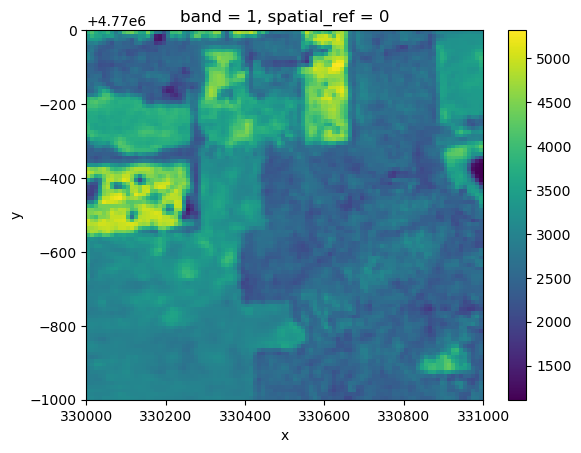

In [38]:
nir_da[0, 3000:3100, 3000:3100].plot()

### Landsat challenge

Repeat the above search for satellite images, but only search the Landsat Level 2 collection ("landsat-c2-l2"). Some questions and tasks to attempt:

- Does the Landsat item contain a visual asset like Sentinel?
- Plot the rendered preview
- What is the resolution of Landsat images and what property tells us this?

The following two resources have some useful information but are not critical to completing the task.

- [https://bitsofanalytics.org/posts/algaebloom-part3/#what-about-those-landsat-images](https://bitsofanalytics.org/posts/algaebloom-part3/#what-about-those-landsat-images)
- [https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/)



### Answer

In [39]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace
)

search = catalog.search(
    collections=["landsat-c2-l2"], bbox=bbox, datetime=target_date_range
)

# see how many items were returned
items_landsat = search.item_collection()
print(f'{len(items_landsat)} items found')
print(f'items_landsat is a {type(items_landsat)}')
print(f'items_landsat[0] is a {type(items_landsat[0])}')

1 items found
items_landsat is a <class 'pystac.item_collection.ItemCollection'>
items_landsat[0] is a <class 'pystac.item.Item'>


Great, it worked. By looking at the `id` values, we can see the specific Sentinel-2 images we found.

In [42]:
for item in items_landsat:
    print(item.id)

LC09_L2SP_020030_20240329_02_T1


Look at the properties for one of the items.

In [43]:
# Sentinel-2 item
item.properties

{'gsd': 30,
 'created': '2024-04-05T09:15:29.066894Z',
 'sci:doi': '10.5066/P9OGBGM6',
 'datetime': '2024-03-29T16:16:10.067858Z',
 'platform': 'landsat-9',
 'proj:epsg': 32617,
 'proj:shape': [8011, 7901],
 'description': 'Landsat Collection 2 Level-2',
 'instruments': ['oli', 'tirs'],
 'eo:cloud_cover': 2.25,
 'proj:transform': [30.0, 0.0, 197385.0, 0.0, -30.0, 4903515.0],
 'view:off_nadir': 0,
 'landsat:wrs_row': '030',
 'landsat:scene_id': 'LC90200302024089LGN00',
 'landsat:wrs_path': '020',
 'landsat:wrs_type': '2',
 'view:sun_azimuth': 149.64018996,
 'landsat:correction': 'L2SP',
 'view:sun_elevation': 46.62426514,
 'landsat:cloud_cover_land': 1.91,
 'landsat:collection_number': '02',
 'landsat:collection_category': 'T1'}

Let's look at the `assets`.


In [45]:
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

qa                        - Surface Temperature Quality Assessment Band
ang                       - Angle Coefficients File
red                       - Red Band
blue                      - Blue Band
drad                      - Downwelled Radiance Band
emis                      - Emissivity Band
emsd                      - Emissivity Standard Deviation Band
trad                      - Thermal Radiance Band
urad                      - Upwelled Radiance Band
atran                     - Atmospheric Transmittance Band
cdist                     - Cloud Distance Band
green                     - Green Band
nir08                     - Near Infrared Band 0.8
lwir11                    - Surface Temperature Band
swir16                    - Short-wave Infrared Band 1.6
swir22                    - Short-wave Infrared Band 2.2
coastal                   - Coastal/Aerosol Band
mtl.txt                   - Product Metadata File (txt)
mtl.xml                   - Product Metadata File (xml)
mtl.json       

Yep, some of the assets are different, though some are shared. 

- Sentinel-2 contains a 'visual' band that includes the red, green, and blue bands
- Landsat has individual red, green and blue bands, but not a convenient 'visual' band
- The `gsd` property of the Landsat item indicates that the resolution is 30m. Sentinel-2 gives us 10m resolution for several of the bands.

In [46]:
Image(url=item.assets["rendered_preview"].href, width=500)